In [1]:
import pandas as pd
import geopandas
import json
import os
from shapely.geometry import Point
from shapely import wkt
import folium
import difflib
from geopy.distance import vincenty
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from shapely.ops import transform
from functools import partial
import pyproj

%matplotlib inline
inline_rc = dict(mpl.rcParams)

in_folder = "audits/2018_07/data/"
out_folder = "audits/2018_07/images/"

In [2]:
osm_lines = pd.read_csv(os.path.join(in_folder, "osm-transit-extractor_lines.csv"), dtype=str)
osm_lines = osm_lines[osm_lines['mode'] == 'bus']

In [3]:
osm_line_route = pd.read_csv(os.path.join(in_folder, "osm-transit-extractor_line_routes.csv"), dtype=str)
tt = pd.DataFrame(osm_line_route.groupby('line_id').count()).reset_index()
tt.rename(columns={'route_id': 'nb_routes'}, inplace=True)
result = pd.merge(osm_lines,tt, on='line_id')

osm_lines = result[['line_id', 'name', 'nb_routes','code', 'colour', 'operator', 'network','shape']].copy()

In [4]:
project = partial(
    pyproj.transform,
    pyproj.Proj(init='EPSG:4326'),
    pyproj.Proj(init='EPSG:2154'))

def osm_shape_to_wkt(row):
    if pd.isna(row['shape']):
        wkt_ = wkt.loads('POINT (2.482068 49.0327237)')
    else :
        wkt_ = wkt.loads(row['shape'])
    return transform(project, wkt_) # on projette, pour avoir plus tard la longueur en mètres

osm_lines['geom'] = osm_lines.apply(osm_shape_to_wkt, axis=1)

In [5]:
osm_lines_geo = geopandas.GeoDataFrame(osm_lines, geometry=osm_lines.geom)

osm_lines_geo.head()
#osm_lines_geo.plot()

,line_id,name,nb_routes,code,colour,operator,network,shape,geom,geometry
0,Line:Relation:36997,Bus 34 : Les Noues RER (Circulaire),2,34,#00B353,Keolis CIF,Les Courriers de l'Île-de-France,"MULTILINESTRING((2.482068 49.0327237, 2.481475...",(LINESTRING (662126.1289399948 6881550.1632409...,(LINESTRING (662126.1289399948 6881550.1632409...
1,Line:Relation:107352,Bus 33 : Les Noues RER (Circulaire),2,33,#007AC2,Keolis CIF,Les Courriers de l'Île-de-France,MULTILINESTRING((2.4747065999999998 49.0313401...,(LINESTRING (661586.8094866406 6881399.8481064...,(LINESTRING (661586.8094866406 6881399.8481064...
2,Line:Relation:107354,Bus 11 : Victor Basch (Goussainville) ↔ Saint-...,2,11,#B456A1,Keolis CIF,Les Courriers de l'Île-de-France,"MULTILINESTRING((2.3552624 48.9384249, 2.35614...",(LINESTRING (652768.0073368527 6871131.9764142...,(LINESTRING (652768.0073368527 6871131.9764142...
3,Line:Relation:107356,"Bus 32 : Goussainville, Victor Basch - Roissypole",2,32,#B2CE40,Keolis CIF,Les Courriers de l'Île-de-France,"MULTILINESTRING((2.4737355 49.0286249, 2.47397...",(LINESTRING (661513.7842904497 6881098.3623743...,(LINESTRING (661513.7842904497 6881098.3623743...
4,Line:Relation:225665,Bus 170 : Saint-Denis RER ↔ Porte des Lilas,2,170,#87d3df,RATP,RATP,"MULTILINESTRING((2.347647 48.9338312, 2.347713...",(LINESTRING (652205.9130451448 6870625.7423249...,(LINESTRING (652205.9130451448 6870625.7423249...


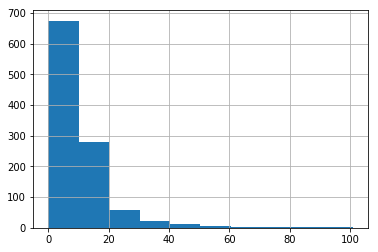

In [6]:
osm_lines_geo['line_length'] = (osm_lines_geo.length/osm_lines_geo['nb_routes'] ) /1000
osm_lines_geo['line_length'].hist()

In [7]:
#analyse des petites lignes
#osm_lines_geo_petit = osm_lines_geo[osm_lines_geo['line_length'] < 3]
#osm_lines_geo_petit.sort_values('line_length', inplace=True,  ascending=False)
#osm_lines_geo_petit

In [8]:
osm_lines_geo_ok = osm_lines_geo[osm_lines_geo['line_length'] >= 3].copy()

osm_lines_geo_ok[['line_id', 'name', 'network', 'line_length']]

print("Nombre de lignes avec tracé : {}".format(len(osm_lines_geo_ok)))

tt = len(osm_lines_geo_ok) * 100.0 / len(osm_lines_geo)
"Pourcentage de lignes OSM qui ont un tracé : {}".format(tt)

Nombre de lignes avec tracé : 758


'Pourcentage de lignes OSM qui ont un tracé : 71.44203581526861'

In [9]:
## rapporté au nombre de lignes du GTFS
gtfs_lines = pd.read_csv(os.path.join(in_folder, "gtfs_routes.txt"), dtype=str)
gtfs_lines = gtfs_lines[gtfs_lines['route_type'] == '3']

tt = len(osm_lines_geo_ok) * 100.0 / len(gtfs_lines)
"Pourcentage de lignes qui ont un tracé : {}".format(tt)


'Pourcentage de lignes qui ont un tracé : 52.78551532033426'

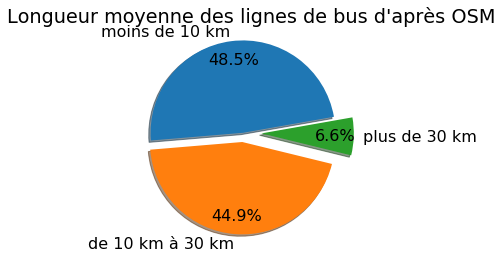

In [10]:
lines_count = len(osm_lines_geo_ok)
labels = 'moins de 10 km', 'de 10 km à 30 km', 'plus de 30 km'
count_petit = len(osm_lines_geo_ok[osm_lines_geo_ok['line_length'] < 10])
count_moyen = len(osm_lines_geo_ok[(osm_lines_geo_ok['line_length'] >= 10) & (osm_lines_geo_ok['line_length'] < 30 )])
count_grand = len(osm_lines_geo_ok[osm_lines_geo_ok['line_length'] > 30])

sizes = [count_petit/lines_count * 100, 
         count_moyen/lines_count * 100,
         count_grand/lines_count * 100]
explode = (0, 0.1, 0.2)

fig1, ax1 = plt.subplots()
plt.rcParams['font.size'] = 16

ax1.set_title("Longueur moyenne des lignes de bus d'après OSM")
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=10, pctdistance=0.8)
ax1.axis('equal') 
plt.savefig(os.path.join(out_folder,'21_longueur_moyenne_lignes.png'), bbox_inches='tight')

In [11]:
#difficile d'estimer la qualité du résultat, 
#mais si on regroupe par réseau, on retrouve bien les réseaux urbains vs les réseaux longues distances

osm_networks = pd.DataFrame(osm_lines_geo_ok.groupby('network').mean()).reset_index()

osm_networks.sort_values(by='line_length', ascending=False, inplace=True)
osm_networks.tail(10)
# petits réseaux urbains (Orgebus, Probus, Chavilbus)

osm_networks.head(10)
# réseaux en car type express (Express A14, Seine-et-Marne Express) 
# ou longue distance (Réseau Interurbain de Rambouillet, Le Bus Direct)

,network,nb_routes,line_length
27,Express A14,2.000000,81.114372
13,CEAT Sud Ile-de-France,4.000000,75.372655
35,Le Bus Direct,2.000000,53.942468
83,Seine-et-Marne Express,2.500000,51.388145
108,Étampois,2.000000,48.657286
28,Flixbus,2.000000,40.879154
86,Still,2.000000,34.301101
66,Réseau interurbain de Rambouillet,2.000000,33.873210
8,Bus Val d'Oise,2.666667,33.107767
73,STILL,2.416667,31.471110
